# Analyzing virtual tfSF using the principles of Information Bottleneck (Simulation 1)

In this notebook we re-run a simulation similar to Simulation 8.1 using a data samples in higher dimenesions.

## Setup

We start by importing some libraries:

In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

import tfSF
import npSF

import data.data_creation as D
from IT import IT

We define the parameters of our simulation:

In [2]:
learned_features = 10
n_samples = 1000
n_epochs = 200

IT_bins=30

We define a couple of helper functions: a simple linear regression function and a helper function to compute the tfSF learned representation as a function of the weights. Notice that here, for simplicity, we call the steps of SF implemented using *numpy*; since no learning is now required, using *numpy* saves us the overhead of instantiating a *tensorflow* model.

In [3]:
def linreg(x,y):
    a, b, _, _, _ = stats.linregress(x,y)
    return a*x+b
    

def computeZ(X,W):
    WX = np.dot(W,X.T)
    F = npSF.softabsolute(WX)
    Fsquish, _ = npSF.l2row(F)
    Fhat, _ = npSF.l2row(Fsquish.T)
    Z = Fhat
    return Z

## Simulation 1

We now train a SF module and we evaluate the mutual information wrt to different possible labelling of the data. Specifically, we load random data togethere with three possible labelling: *Gaussian, radial, random*.

In [5]:
X, Y_radial, Y_random = D.get_samples_virtualSF_hd(n_dims=10,n_samples=n_samples)

We train the SF module.

In [6]:
tfsf = tfSF.SFilter(n_features=learned_features)
tfsf.fit(X, epochs=n_epochs, batchsize=n_samples*2)

Epoch 1/200
2/2 [==============================] - 0s 6ms/step - loss: 4563.9556
Epoch 2/200
2/2 [==============================] - 0s 6ms/step - loss: 4248.8799
Epoch 3/200
2/2 [==============================] - 0s 4ms/step - loss: 4032.1797
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 3913.5950
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 3834.2473
Epoch 6/200
2/2 [==============================] - 0s 3ms/step - loss: 3759.8354
Epoch 7/200
2/2 [==============================] - 0s 4ms/step - loss: 3707.7974
Epoch 8/200
2/2 [==============================] - 0s 3ms/step - loss: 3692.0559
Epoch 9/200
2/2 [==============================] - 0s 4ms/step - loss: 3653.4016
Epoch 10/200
2/2 [==============================] - 0s 3ms/step - loss: 3630.2959
Epoch 11/200
2/2 [==============================] - 0s 5ms/step - loss: 3615.3936
Epoch 12/200
2/2 [==============================] - 0s 3ms/step - loss: 3588.2749
Epoch 13/200
2/2 [=======

2/2 [==============================] - 0s 5ms/step - loss: 3446.8779
Epoch 198/200
2/2 [==============================] - 0s 4ms/step - loss: 3446.6497
Epoch 199/200
2/2 [==============================] - 0s 6ms/step - loss: 3444.3210
Epoch 200/200
2/2 [==============================] - 0s 5ms/step - loss: 3448.1841


We plot the loss function to verify that the model converged to a solution.

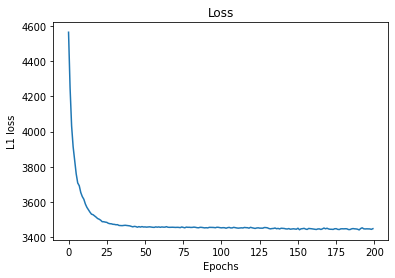

In [7]:
plt.title('Loss'); 
plt.xlabel('Epochs'); 
plt.ylabel('L1 loss');
    
plt.plot(tfsf.hist.history['loss'])

We compute the mutual information of the learned representations and the different types of labelling.

In [8]:
Ws = tfsf.weights

MI_radial = []; MI_random = []
  
for W in Ws:
    Z = computeZ(X,W)
    
    MI_radial.append(IT.compute_MI_dd_bin(Z,Y_radial,n_bins=IT_bins))
    MI_random.append(IT.compute_MI_dd_bin(Z,Y_random,n_bins=IT_bins))

We plot entropy and mutual information.

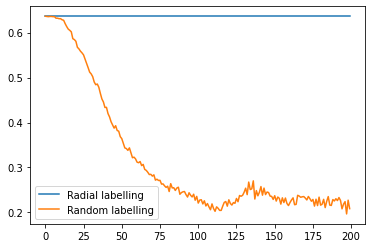

In [9]:
mis = [MI_radial, MI_random]
titles = ['Radial labelling', 'Random labelling']

for i in range(len(mis)):
    plt.plot(mis[i],label=titles[i])
plt.legend()

In [13]:
labelixs_radial = {}
labelixs_radial['0'] = (Y_radial==0).squeeze()
labelixs_radial['1'] = (Y_radial==1).squeeze()
labelixs_radial['2'] = (Y_radial==2).squeeze()

labelixs_random = {}
labelixs_random['0'] = (Y_random==0).squeeze()
labelixs_random['1'] = (Y_random==1).squeeze()
labelixs_random['2'] = (Y_random==2).squeeze()

In [16]:
Ws = tfsf.weights

MI_radial = []; MI_random = []
  
for W in Ws:
    Z = computeZ(X,W)
    
    _,mi = IT.compute_MI_ld_bin(labelixs_radial,Z,bins=IT_bins)
    MI_radial.append(mi)
    _,mi = IT.compute_MI_ld_bin(labelixs_random,Z,bins=IT_bins)
    MI_random.append(mi)

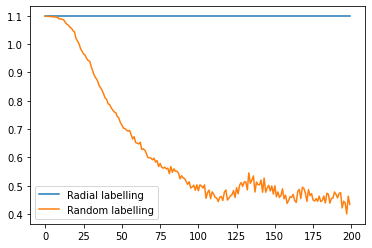

In [17]:
mis = [MI_radial, MI_random]
titles = ['Radial labelling', 'Random labelling']

for i in range(len(mis)):
    plt.plot(mis[i],label=titles[i])
plt.legend()

## Conclusions

- Results on MI seems to hold even with samples in a higher-dimensional space.

### References

[1] Zennaro, F.M. and Chen, K., 2019. Towards Further Understanding of Sparse Filtering via Information Bottleneck. arXiv preprint arXiv:1910.08964.